The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-beta0


# Multi-Fidelity Hyperparameter Optimization
:label:`sec_mf_hpo`

Training neural networks can be expensive even on moderate size datasets.
Depending on the configuration space (:numref:`sec_intro_config_spaces`),
hyperparameter optimization requires tens to hundreds of function evaluations
to find a well-performing hyperparameter configuration. As we have seen in
:numref:`sec_rs_async`, we can significantly speed up the overall wall-clock
time of HPO by exploiting parallel resources, but this does not reduce the total
amount of compute required.

In this section, we will show how the evaluation of hyperparameter configurations
can be sped up. Methods such as random search allocate the same amount of
resources (e.g., number of epochs, training data points) to each hyperparameter
evaluation. :numref:`img_samples_lc` depicts learning curves of a set of neural
networks trained with different hyperparameter configurations. After a few epochs we are
already able to visually distinguish between well-performing and suboptimal
configurations. However, the learning curves are noisy, and we might still require
the full amount of 100 epochs to identify the best performing one.

![Learning curves of random hyperparameter configurations](http://d2l.ai/_images/samples_lc.svg)
:label:`img_samples_lc`

Multi-fidelity hyperparameter optimization allocates more resources
to promising configurations and stop evaluations of poorly performing ones early.
This speeds up the optimization process, since we can try a larger number of
configurations for the same total amount of resources.

More formally, we expand our definition in :numref:`sec_definition_hpo`,
such that our objective function $f(\mathbf{x}, r)$ gets an additional input
$r \in [r_{\text{min}}, r_{max}]$, specifying the amount of resources that we are
willing to spend for the evaluation of configuration $\mathbf{x}$. We assume that
the error $f(\mathbf{x}, r)$ decreases with $r$, whereas the computational
cost $c(\mathbf{x}, r)$ increases. Typically, $r$ represents the number of
epochs for training the neural network, but it could also be the training
subset size or the number of cross-validation folds.


In [1]:
from collections import defaultdict
import numpy as np
from scipy import stats
from d2l import torch as d2l

d2l.set_figsize()

## Successive Halving
:label:`sec_mf_hpo_sh`

One of the simplest ways to adapt random search to the multi-fidelity setting is
*successive halving* :cite:`jamieson-aistats16,karnin-icml13`. The basic
idea is to start with $N$ configurations, for example randomly sampled from the
configuration space, and to train each of them for $r_{\text{min}}$ epochs only. We
then discard a fraction of the worst performing trials and train the remaining
ones for longer. Iterating this process, fewer trials run for longer, until at
least one trial reaches $r_{max}$ epochs.

More formally, consider a minimum budget $r_{\text{min}}$ (for example 1 epoch), a maximum
budget $r_{max}$, for example `max_epochs` in our previous example, and a halving
constant $\eta\in\{2, 3, \dots\}$. For simplicity, assume that
$r_{max} = r_{\text{min}} \eta^K$, with $K \in \mathbb{I}$ . The number of initial
configurations is then $N = \eta^K$. Let us define the set of rungs
$\mathcal{R} = \{ r_{\text{min}}, r_{\text{min}}\eta, r_{\text{min}}\eta^2, \dots, r_{max} \}$.

One round of successive halving proceeds as follows. We start with running $N$
trials until the first rung $r_{\text{min}}$. Sorting the validation errors, we keep
the top $1 / \eta$ fraction (which amounts to $\eta^{K-1}$ configurations) and
discard all the rest. The surviving trials are trained for the next rung
($r_{\text{min}}\eta$ epochs), and the process is repeated. At each rung, a
$1 / \eta$ fraction of trials survives and their training continues with a
$\eta$ times larger budget. With this particular choice of $N$, only a single
trial will be trained to the full budget $r_{max}$. Once such a round of
successive halving is done, we start the next one with a new set of initial
configurations, iterating until the total budget is spent.

![Learning curves of random hyperparameter configurations.](http://d2l.ai/_images/sh.svg)

We subclass the `HPOScheduler` base class from :numref:`sec_api_hpo` in order to
implement successive halving, allowing for a generic `HPOSearcher` object to
sample configurations (which, in our example below, will be a `RandomSearcher`).
Additionally, the user has to pass the minimum resource $r_{\text{min}}$, the maximum
resource $r_{max}$ and $\eta$ as input. Inside our scheduler, we maintain a
queue of configurations that still need to be evaluated for the current rung
$r_i$. We update the queue every time we jump to the next rung.


In [2]:
class SuccessiveHalvingScheduler(d2l.HPOScheduler):  #@save
    def __init__(self, searcher, eta, r_min, r_max, prefact=1):
        self.save_hyperparameters()
        # Compute K, which is later used to determine the number of configurations
        self.K = int(np.log(r_max / r_min) / np.log(eta))
        # Define the rungs
        self.rung_levels = [r_min * eta ** k for k in range(self.K + 1)]
        if r_max not in self.rung_levels:
            # The final rung should be r_max
            self.rung_levels.append(r_max)
            self.K += 1
        # Bookkeeping
        self.observed_error_at_rungs = defaultdict(list)
        self.all_observed_error_at_rungs = defaultdict(list)
        # Our processing queue
        self.queue = []

In the beginning our queue is empty, and we fill it with
$n = \mathrm{prefact} \cdot \eta^{K}$ configurations, which are first evaluated on
the smallest rung $r_{\text{min}}$. Here, $\mathrm{prefact}$ allows us to reuse our
code in a different context. For the purpose of this section, we fix
$\mathrm{prefact} = 1$. Every time resources become available and the `HPOTuner`
object queries the `suggest` function, we return an element from the queue. Once
we finish one round of successive halving, which means that we evaluated all
surviving configurations on the highest resource level $r_{max}$ and our queue
is empty, we start the entire process again with a new, randomly sampled set
of configurations.


In [3]:
@d2l.add_to_class(SuccessiveHalvingScheduler)  #@save
def suggest(self):
    if len(self.queue) == 0:
        # Start a new round of successive halving
        # Number of configurations for the first rung:
        n0 = int(self.prefact * self.eta ** self.K)
        for _ in range(n0):
            config = self.searcher.sample_configuration()
            config["max_epochs"] = self.r_min  # Set r = r_min
            self.queue.append(config)
    # Return an element from the queue
    return self.queue.pop()

When we collected a new data point, we first update the searcher module.
Afterwards we check if we already collect all data points on the current rung.
If so, we sort all configurations and push the top $\frac{1}{\eta}$
configurations into the queue.


In [4]:
@d2l.add_to_class(SuccessiveHalvingScheduler)  #@save
def update(self, config: dict, error: float, info=None):
    ri = int(config["max_epochs"])  # Rung r_i
    # Update our searcher, e.g if we use Bayesian optimization later
    self.searcher.update(config, error, additional_info=info)
    self.all_observed_error_at_rungs[ri].append((config, error))
    if ri < self.r_max:
        # Bookkeeping
        self.observed_error_at_rungs[ri].append((config, error))
        # Determine how many configurations should be evaluated on this rung
        ki = self.K - self.rung_levels.index(ri)
        ni = int(self.prefact * self.eta ** ki)
        # If we observed all configuration on this rung r_i, we estimate the
        # top 1 / eta configuration, add them to queue and promote them for
        # the next rung r_{i+1}
        if len(self.observed_error_at_rungs[ri]) >= ni:
            kiplus1 = ki - 1
            niplus1 = int(self.prefact * self.eta ** kiplus1)
            best_performing_configurations = self.get_top_n_configurations(
                rung_level=ri, n=niplus1
            )
            riplus1 = self.rung_levels[self.K - kiplus1]  # r_{i+1}
            # Queue may not be empty: insert new entries at the beginning
            self.queue = [
                dict(config, max_epochs=riplus1)
                for config in best_performing_configurations
            ] + self.queue
            self.observed_error_at_rungs[ri] = []  # Reset

Configurations are sorted based on their observed performance on the current
rung.


In [5]:
@d2l.add_to_class(SuccessiveHalvingScheduler)  #@save
def get_top_n_configurations(self, rung_level, n):
    rung = self.observed_error_at_rungs[rung_level]
    if not rung:
        return []
    sorted_rung = sorted(rung, key=lambda x: x[1])
    return [x[0] for x in sorted_rung[:n]]

Let us see how successive halving is doing on our neural network example. We
will use $r_{\text{min}} = 2$, $\eta = 2$, $r_{max} = 10$, so that rung levels are
$2, 4, 8, 10$.


In [6]:
min_number_of_epochs = 2
max_number_of_epochs = 10
eta = 2
num_gpus=1

config_space = {
    "learning_rate": stats.loguniform(1e-2, 1),
    "batch_size": stats.randint(32, 256),
}
initial_config = {
    "learning_rate": 0.1,
    "batch_size": 128,
}

We just replace the scheduler with our new `SuccessiveHalvingScheduler`.


    error = 0.15941745042800903, runtime = 50.94357347488403


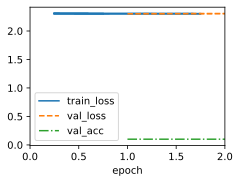

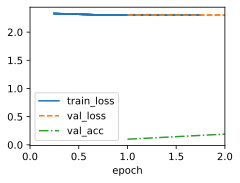

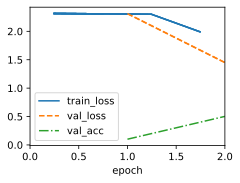

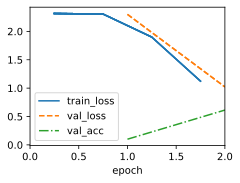

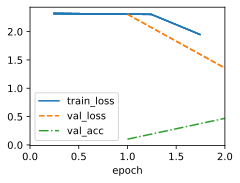

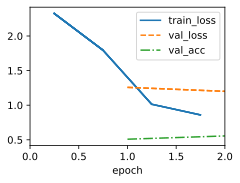

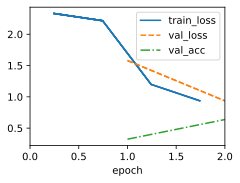

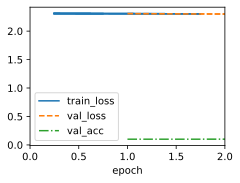

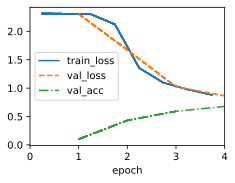

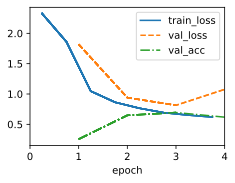

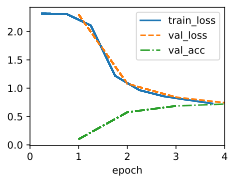

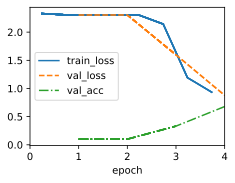

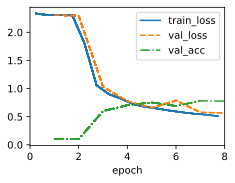

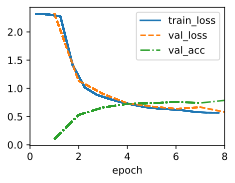

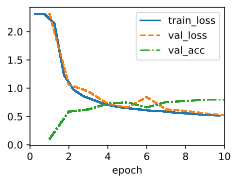

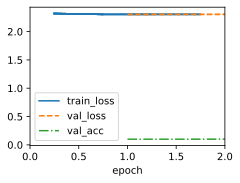

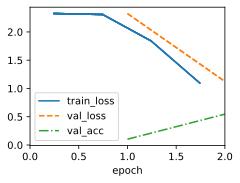

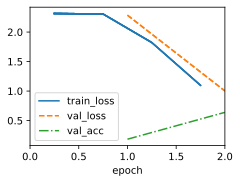

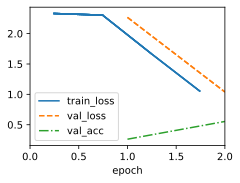

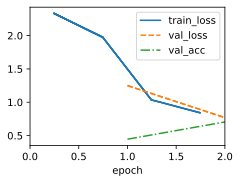

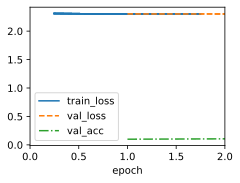

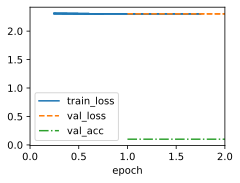

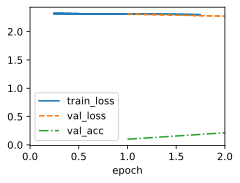

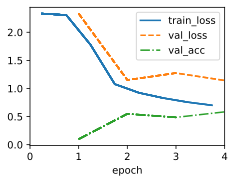

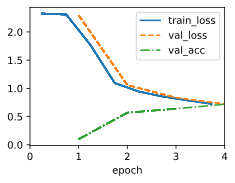

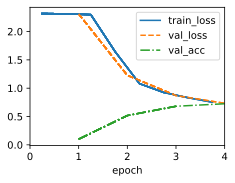

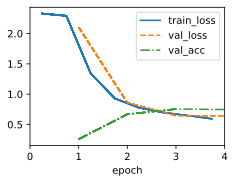

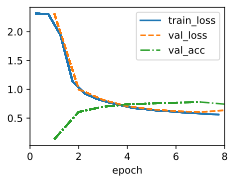

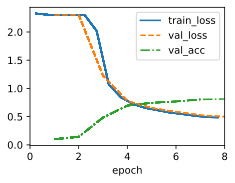

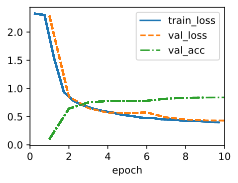

In [7]:
searcher = d2l.RandomSearcher(config_space, initial_config=initial_config)
scheduler = SuccessiveHalvingScheduler(
    searcher=searcher,
    eta=eta,
    r_min=min_number_of_epochs,
    r_max=max_number_of_epochs,
)
tuner = d2l.HPOTuner(
    scheduler=scheduler,
    objective=d2l.hpo_objective_lenet,
)
tuner.run(number_of_trials=30)

We can visualize the learning curves of all configurations that we evaluated.
Most of the configurations are stopped early and only the better performing
configurations survive until $r_{max}$. Compare this to vanilla random search,
which would allocate $r_{max}$ to every configuration.


Text(0.5, 0, 'epochs')

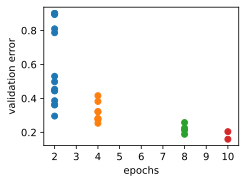

In [8]:
for rung_index, rung in scheduler.all_observed_error_at_rungs.items():
    errors = [xi[1] for xi in rung]
    d2l.plt.scatter([rung_index] * len(errors), errors)
d2l.plt.xlim(min_number_of_epochs - 0.5, max_number_of_epochs + 0.5)
d2l.plt.xticks(
    np.arange(min_number_of_epochs, max_number_of_epochs + 1),
    np.arange(min_number_of_epochs, max_number_of_epochs + 1)
)
d2l.plt.ylabel("validation error")
d2l.plt.xlabel("epochs")

Finally, note some slight complexity in our implementation of
`SuccessiveHalvingScheduler`. Say that a worker is free to run a job, and
`suggest` is called when the current rung has almost been completely filled, but
another worker is still busy with an evaluation. Since we lack the metric value
from this worker, we cannot determine the top $1 / \eta$ fraction to open up
the next rung. On the other hand, we want to assign a job to our free worker,
so it does not remain idle. Our solution is to start a new round of successive
halving and assign our worker to the first trial there. However, once a rung is
completed in `update`, we make sure to insert new configurations at the
beginning of the queue, so they take precedence over configurations from the
next round.

## Summary

In this section, we introduced the concept of multi-fidelity hyperparameter
optimization, where we assume to have access to cheap-to-evaluate approximations
of the objective function, such as validation error after a certain number of
epochs of training as proxy to validation error after the full number of epochs.
Multi-fidelity hyperparameter optimization allows to reduce the overall
computation of the HPO instead of just reducing the wall-clock time.

We implemented and evaluated successive halving, a simple yet efficient
multi-fidelity HPO algorithm.


[Discussions](https://discuss.d2l.ai/t/12094)
